In [1]:
import numpy as np
from scipy.signal import medfilt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from skimage.io import imread, imsave, imshow
import cupy as cp
import cupyx.scipy.ndimage as ndigpu
import pandas as pd


In [2]:
imstack = imread(r"H:\Urs_data\calibration_gc6_2.tif")

C:\Users\jlab\anaconda3_new_install\envs\rf_scope\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


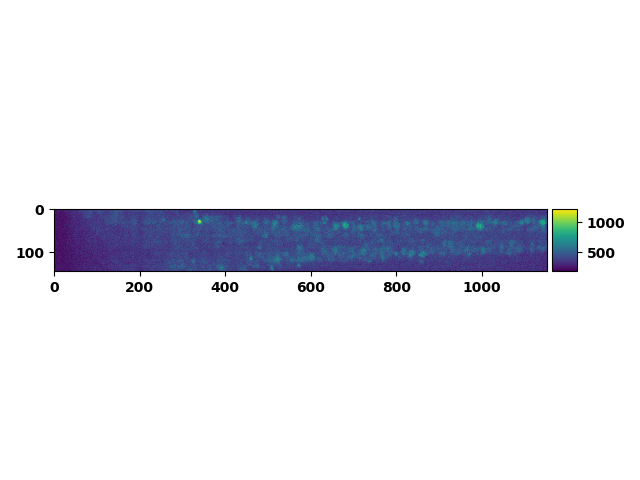

In [3]:
%matplotlib widget
# image = imstack[32:31*2,:,512:]
image = imstack
imshow(image[10,:,:])

In [4]:
def warp_polar_gpu(image, radius):
            
            # This funciton was developed by Niels Cautaerts
            
            cx, cy = image.shape[1] / 2, image.shape[0] / 2
            output_shape = (360, radius)
            T = cp.linspace(0, 2*np.pi, output_shape[0]).reshape(output_shape[0], 1)
            R = cp.arange(output_shape[1]).reshape(1, output_shape[1])
            X = R * cp.cos(T) + cx
            Y = R * cp.sin(T) + cy
            coordinates = cp.stack([Y, X])
            polar = ndigpu.map_coordinates(image, coordinates, order=1)
            
            return polar
        
radius = int(np.ceil(np.sqrt((image.shape[0] / 2)**2 + (image.shape[1] / 2)**2)))
img_polar = np.zeros((image.shape[0], 360, radius))    

for i in range(image.shape[0]):

    tmp=cp.absolute(cp.fft.fftshift(cp.fft.fft2(cp.asarray(image[i]))))
    img_polar[i]= warp_polar_gpu(tmp,radius).get()


In [5]:
def projection_img(image):
    img_project = np.zeros((image.shape[0], image.shape[2]))
    for i in range(image.shape[0]):
        img_project[i] = np.log((np.sum(image[i], axis=0)))
    return img_project
    
img_project = projection_img(img_polar)

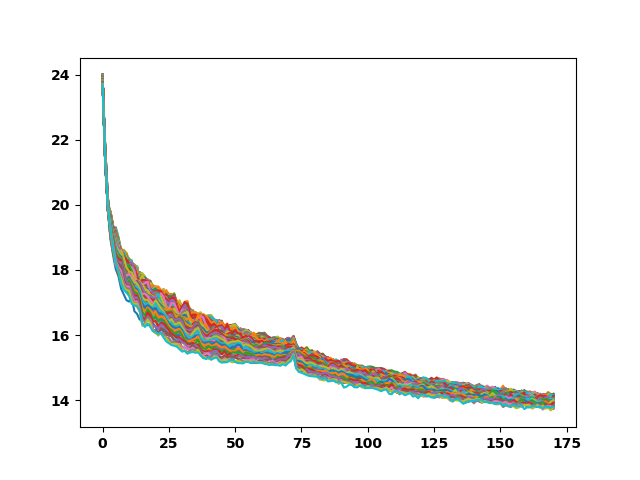

In [6]:
%matplotlib widget
plt.plot(img_project.T[::])

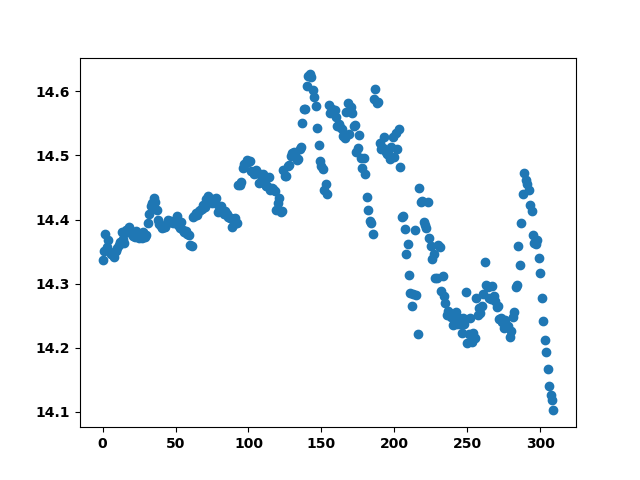

In [7]:
%matplotlib widget
def focus_measure(image):
    img_measure = np.zeros(image.shape[0])

    base_ind=int(image.shape[1]*0.5)
    for i in range(image.shape[0]):
        
#         baseline=image[i][base_ind:]
#         inds=np.where(medfilt(image[i][:base_ind],11)<(baseline.mean()+baseline.std()*3))[0]
        
#         if isinstance(inds, np.ndarray) and inds.size>0:
#             img_measure[i] = inds.min()
#         else:
#             img_measure[i] = 0
        img_measure[i] = image[i,base_ind:].mean()
    return img_measure

img_measure = focus_measure(img_project)
plt.scatter(range(len(img_measure)), img_measure)

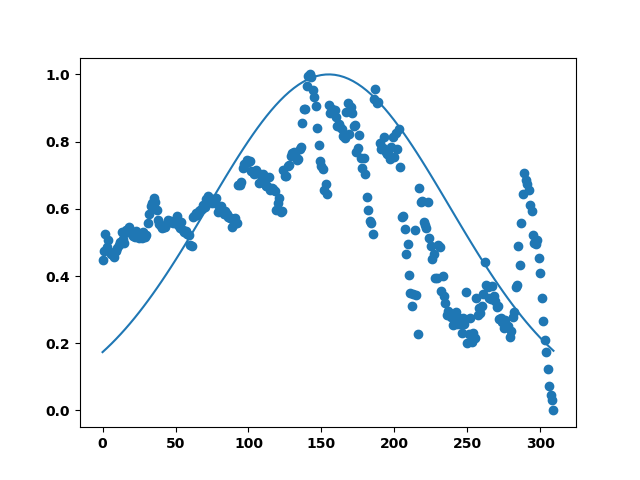

In [8]:
def func(x,args):
        
        target=args
        x_axis=np.arange(len(target))

        y=np.exp(-x[0]*(x_axis-x[1])**2)
        
        return np.sum((target-y)**2)

trace = img_measure
    
trace_norm=(trace-trace.min())/(trace.max()-trace.min())
x_init=[0.001,len(trace)/2]
x_bound=[[0,0.1],[5,len(trace)-5]]
result=minimize(func, x_init, args=(trace_norm), method='L-BFGS-B',bounds=x_bound)

x=np.arange(len(trace_norm))
%matplotlib widget
plt.scatter(x, trace_norm)
plt.plot(np.linspace(x[0],x[-1],100), np.exp(-result.x[0]*(np.linspace(x[0],x[-1],100)-result.x[1])**2))

In [39]:
%matplotlib widget
baseline=img_project[3][base_ind:]
inds=np.where(medfilt(img_project[3][:base_ind],11)<(baseline.mean()+baseline.std()*3))[0]
plt.plot(img_project[3][:-1])
plt.plot(medfilt(img_project[3][:-1],11))
print(baseline.mean()+baseline.std()*3)
print(medfilt(img_project[3][:base_ind],11).min())

NameError: name 'base_ind' is not defined

In [40]:
wf = pd.read_csv(r"C:\Users\jlab\Documents\rf_control\data0069.csv", sep=',')

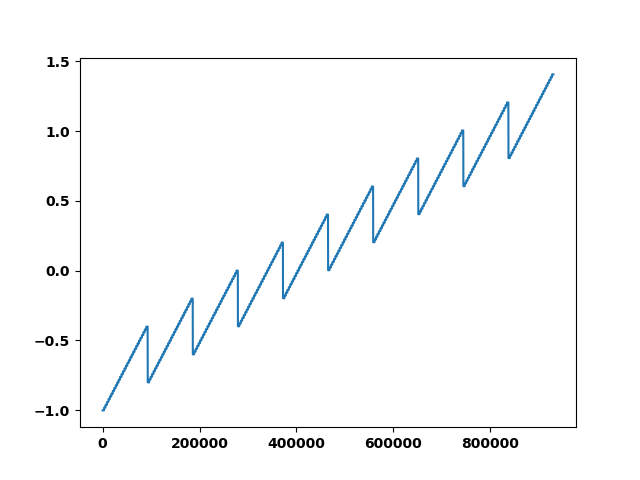

In [41]:
%matplotlib widget
plt.plot((wf.values[:,2]))

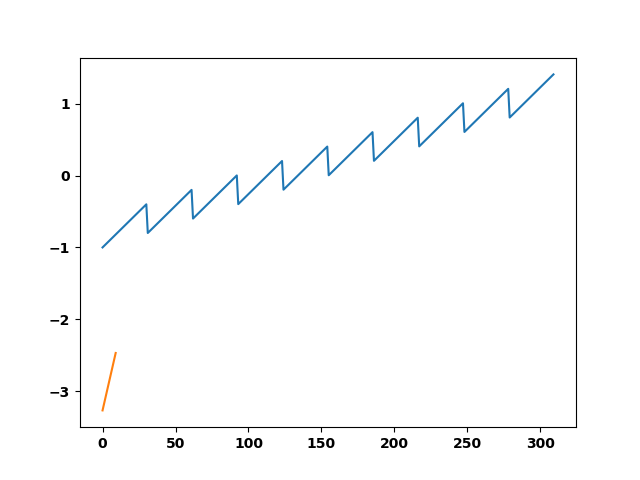

In [42]:
%matplotlib widget
# plt.plot((wf.values[:,0]))
dv = np.diff(wf.values[:,2])
idx = np.nonzero(dv)
idx = idx[0] + 1
idx = np.append(0, idx)
vals_ls = wf.values[idx,2]
plt.plot(vals_ls)
vals_ls = np.reshape(vals_ls, (int(len(vals_ls)/31), 31))
vals_ls = vals_ls.T
dv = np.diff(wf.values[:,1])
idx = np.nonzero(dv)
idx = idx[0] + 1
idx = np.append(0, idx)
vals_vc = wf.values[idx,1]
plt.plot(vals_vc)

In [43]:
def func(x,args, x_axis):
        
        target=args
        # x_axis=np.arange(len(target))

        y=np.exp(-x[0]*(x_axis-x[1])**2)
        
        return np.sum((target-y)**2)

n_steps = int(imstack.shape[0]/31)
means = np.zeros(n_steps,)
for n in range(n_steps):
    image = imstack[n*31:(n+1)*31,:,512:]
    radius = int(np.ceil(np.sqrt((image.shape[0] / 2)**2 + (image.shape[1] / 2)**2)))
    img_polar = np.zeros((image.shape[0], 360, radius))    

    for i in range(image.shape[0]):

        tmp=cp.absolute(cp.fft.fftshift(cp.fft.fft2(cp.asarray(image[i]))))
        img_polar[i]= warp_polar_gpu(tmp,radius).get()
    
    img_project = projection_img(img_polar)
    
    trace = focus_measure(img_project)
    
    trace_norm=(trace-trace.min())/(trace.max()-trace.min())
    xAx = vals_ls[:,n]
    x_init=[0.001,xAx[16]]
    x_bound=[[0,0.1],[xAx[5],xAx[-5]]]
    result=minimize(func, x_init, args=(trace_norm, xAx), method='L-BFGS-B',bounds=x_bound)
    
    means[n] = result.x[1]
    

    

a: 8.712252114750372e-15, b: 2.262828535669637, c: 6.916186483103952


Text(0, 0.5, 'best light sheet position (V)')

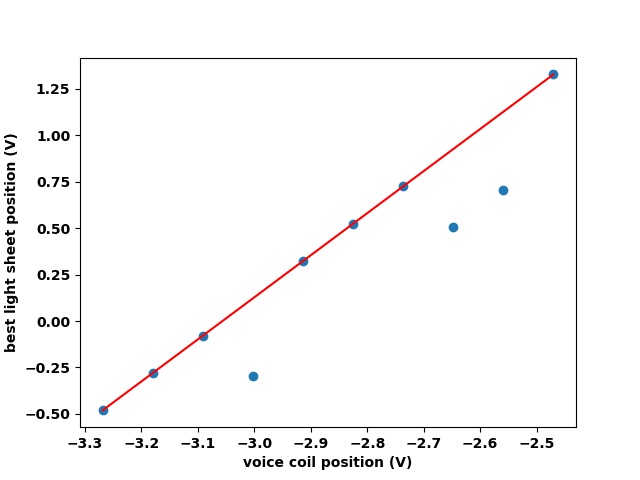

In [ ]:
%matplotlib widget
# x = np.linspace(0,100,10)

plt.scatter(vals_vc, means)
# plt.plot(np.array([x[0], x[-1]]), np.array([vals_ls[0], vals_ls[-1]]))
# plt.plot(vals_vc, vals_ls[16,:])
a, b, c = np.polyfit(vals_vc[(0,1,2,4,5,6,9),], means[(0,1,2,4,5,6,9),], 2)
plt.plot(vals_vc, a*vals_vc**2 + b*vals_vc + c, color='red')
print('a: ' + str(a) + ', b: ' + str(b) + ', c: ' + str(c))
ax = plt.gca()
ax.set_xlabel('voice coil position (V)')
ax.set_ylabel('best light sheet position (V)')

In [52]:
tt = np.asarray([1, 2, 3, 4, 5])

In [60]:
tt[(0, 3, 4),]

array([1, 4, 5])

In [61]:
tt.shape

(5,)